# **Naive Model**



In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [33]:
data = pd.read_csv("datasets/Video_Games_Sales_as_at_22_Dec_2016.csv")

In [34]:
# Identify empty cells

data.isnull().sum()
data_cleaned = data.dropna()

print(f"Rows before cleaning: {data.shape[0]}")
print(f"Rows after cleaning: {data_cleaned.shape[0]}")

# Identify categorical columns
categorical_columns = data_cleaned.select_dtypes(include=['object']).columns.tolist()
print("Categorical columns:", categorical_columns)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor


# Print unique value counts for each categorical column
for col in categorical_columns:
  unique_count = data_cleaned[col].nunique()
  print(f"Unique values in {col}: {unique_count}")


X = data_cleaned.drop(columns=["Critic_Score", 'Name'])  # Drop 'Critic_Score' and 'Name' columns
y = data_cleaned["Critic_Score"]

# Label encode 'Developer' column
label_encoder = LabelEncoder()
X['Developer_encoded'] = label_encoder.fit_transform(X['Developer'])

# Drop the original 'Developer' column
X = X.drop(columns=['Developer'])

# One-hot encode the other categorical columns: 'Platform', 'Genre', 'Publisher', 'User_Score', 'Rating'
# We will use pd.get_dummies for simplicity
X = pd.get_dummies(X, columns=['Platform', 'Genre', 'Publisher', 'User_Score', 'Rating'], drop_first=True)


Rows before cleaning: 16719
Rows after cleaning: 6825
Categorical columns: ['Name', 'Platform', 'Genre', 'Publisher', 'User_Score', 'Developer', 'Rating']
Unique values in Name: 4377
Unique values in Platform: 17
Unique values in Genre: 12
Unique values in Publisher: 262
Unique values in User_Score: 89
Unique values in Developer: 1289
Unique values in Rating: 7


In [35]:
# Split the dataset into training and testing sets
X_old_train, X_old_test, y_old_train, y_old_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Train the XGBoost model
model = XGBRegressor(random_state=42)
model.fit(X_old_train, y_old_train)

# Make predictions
y_old_pred = model.predict(X_old_test)

# Calculate prediction residuals
old_residuals = y_old_pred - y_old_test

# Embedded Model

In [36]:
!pip install category_encoders
!pip install scikit-learn
!pip install scikit-optimize

In [37]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from itertools import product
import xgboost as xgb
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

# 1. Load and Preprocess Data
data = pd.read_csv("datasets/Video_Games_Sales_as_at_22_Dec_2016.csv")

# Handle Missing Values
num_cols = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = data.select_dtypes(include=['object', 'category']).columns.tolist()

num_imputer = SimpleImputer(strategy='mean')
data[num_cols] = num_imputer.fit_transform(data[num_cols])

cat_imputer = SimpleImputer(strategy='most_frequent')
data[cat_cols] = cat_imputer.fit_transform(data[cat_cols])

# Cap outliers in numerical features
for col in ['Global_Sales', 'Critic_Score']:
    upper_limit = data[col].quantile(0.95)
    lower_limit = data[col].quantile(0.05)
    data[col] = np.clip(data[col], lower_limit, upper_limit)

num_cols.remove('Critic_Score')

from sklearn.utils import resample

# Define the target and features
y = data["Critic_Score"]
X = data.drop(columns=["Critic_Score"])

# Check for imbalance in target variable
# print(y.value_counts())

# Combine features and target into a single DataFrame
data = pd.concat([X, y], axis=1)

threshold = 60

# Split data into groups based on the target variable's ranges
minority = data[data['Critic_Score'] < threshold]
majority = data[data['Critic_Score'] >= threshold]

# Oversample the minority group
minority_oversampled = resample(minority,
                                replace=True,
                                n_samples=len(majority),
                                random_state=42)

# Combine oversampled minority with the majority
balanced_data = pd.concat([majority, minority_oversampled])

# Separate features and target again
X_balanced = balanced_data.drop(columns=['Critic_Score'])
y_balanced = balanced_data['Critic_Score']


# 2. Build Entity Embeddings Model (Keras)
categorical_inputs = []
embedding_outputs = []
embedding_feature_names = []

for col in cat_cols:
    # Input layer for the categorical column
    cat_input = keras.Input(shape=(1,), name=col)
    categorical_inputs.append(cat_input)

    # Determine the number of unique values for embedding size
    num_unique_values = data[col].nunique()
    embedding_dim = int(min(np.ceil(num_unique_values / 2), 50))

    # Create embedding layer
    embedding_layer = layers.Embedding(input_dim=num_unique_values + 1, output_dim=embedding_dim, name=col + '_embedding')(cat_input)

    # Flatten the embedding layer to get a single vector for the column
    embedding_output = layers.Flatten()(embedding_layer)
    embedding_outputs.append(embedding_output)

    # Update embedding feature names (one per categorical feature)
    embedding_feature_names.extend([f"{col}_emb_{i}" for i in range(embedding_dim)])

# Concatenate embeddings and numerical features
all_embeddings = layers.concatenate(embedding_outputs)
numerical_input = keras.Input(shape=(len(num_cols),), name='numerical_features')
merged_features = layers.concatenate([all_embeddings, numerical_input])

hidden_layer = layers.Dense(64, activation='relu')(merged_features)
output_layer = layers.Dense(1, activation='linear')(hidden_layer)

embedding_model_full = keras.Model(inputs=categorical_inputs + [numerical_input], outputs=output_layer)
embedding_model_full.compile(optimizer='adam', loss='mse', metrics=['mae'])


# 3. Prepare Data for Training
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

X = data[cat_cols + num_cols]
y = data['Critic_Score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])


# 4. Train Keras Entity Embeddings Model
cat_train_inputs = [X_train[col].values.reshape(-1, 1) for col in cat_cols]
cat_test_inputs = [X_test[col].values.reshape(-1, 1) for col in cat_cols]

embedding_model_full.fit(
    cat_train_inputs + [X_train[num_cols]],
    y_train,
    epochs=50,
    batch_size=32
)


# 5. Extract Embeddings
embedding_extractor = keras.Model(inputs=categorical_inputs, outputs=all_embeddings)
X_train_emb = embedding_extractor.predict(cat_train_inputs)
X_test_emb = embedding_extractor.predict(cat_test_inputs)

# Create DataFrame for embeddings with proper feature names
embedding_df = pd.DataFrame(X_train_emb, columns=embedding_feature_names)

# Apply PCA to the embeddings and get descriptive feature names
pca = PCA(n_components=0.95)  # Keep components explaining 95% of variance
X_train_emb_pca = pca.fit_transform(X_train_emb)
X_test_emb_pca = pca.transform(X_test_emb)

# Get PCA loadings (component weights)
loadings = pd.DataFrame(
    pca.components_,
    columns=embedding_feature_names
)

# Create descriptive names for PCA components based on top contributing features
pca_feature_names = []
for i in range(loadings.shape[0]):
    # Get the top 2 features with highest absolute contribution for this component
    top_features = loadings.iloc[i].abs().sort_values(ascending=False).head(2).index.tolist()
    # Extract base column names (without emb_X suffix)
    base_features = [feat.split('_emb_')[0] for feat in top_features]
    # Create a descriptive name for the component
    unique_base_features = list(dict.fromkeys(base_features))  # Remove duplicates while preserving order
    component_name = f"PC{i+1}_{'+'.join(unique_base_features)}"
    pca_feature_names.append(component_name)

# print(f"Number of PCA components: {len(pca_feature_names)}")
# print("Sample PCA component names:", pca_feature_names[:5])

# Combine PCA-transformed embeddings with numerical features
X_train_final = np.concatenate([X_train_emb_pca, X_train[num_cols].values], axis=1)
X_test_final = np.concatenate([X_test_emb_pca, X_test[num_cols].values], axis=1)

# Create final feature names list
all_feature_names = pca_feature_names + num_cols

# 6. XGBoost Model Training & Hyperparameter Tuning
param_grid = {
    'learning_rate': [0.05, 0.1, 0.15, 0.17],
    'max_depth': [3, 7, 8, 9],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

best_results = []
for params in product(*param_grid.values()):
    param_dict = dict(zip(param_grid.keys(), params))
    param_dict.update({
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse'
    })

    dtrain_emb = xgb.DMatrix(X_train_final, label=y_train, feature_names=all_feature_names)
    results = xgb.cv(params=param_dict, dtrain=dtrain_emb, nfold=3,
                     metrics='rmse', as_pandas=True, seed=42)
    best_results.append((results['test-rmse-mean'].min(), param_dict))

best_score, best_params = min(best_results, key=lambda x: x[0])
# print("Best Parameters:", best_params)

# 7. Create DataFrames with descriptive feature names
train_df = pd.DataFrame(X_train_final, columns=all_feature_names)
test_df = pd.DataFrame(X_test_final, columns=all_feature_names)

# 8. Train XGBoost with best parameters
xgb_model = XGBRegressor(**best_params, random_state=42)
xgb_model.fit(train_df, y_train)

# 9. Model Evaluation
y_pred = xgb_model.predict(test_df)



Epoch 1/50
418/418 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 2430.6733 - mae: 41.3582
Epoch 2/50
418/418 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 49.4302 - mae: 5.3193
Epoch 3/50
418/418 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 17.6086 - mae: 2.9368
Epoch 4/50
418/418 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 10.4807 - mae: 2.1739
Epoch 5/50
418/418 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 8.4111 - mae: 1.9765
Epoch 6/50
418/418 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 7.9037 - mae: 1.9205
Epoch 7/50
418/418 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 7.5160 - mae: 1.8571
Epoch 8/50
418/418 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 6.9889 - mae: 1.7784
Epoch 9/50
418/418 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 6.5457 - mae: 1.7097
Epoch 10/50
418/418 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 6.6741 - mae: 1.7149
Epoch 11/50
418/418 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 6.1796 - mae: 1.6580
Epoch 12/50
418/418 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 6.1351 - mae: 1.6439
Epoch 1

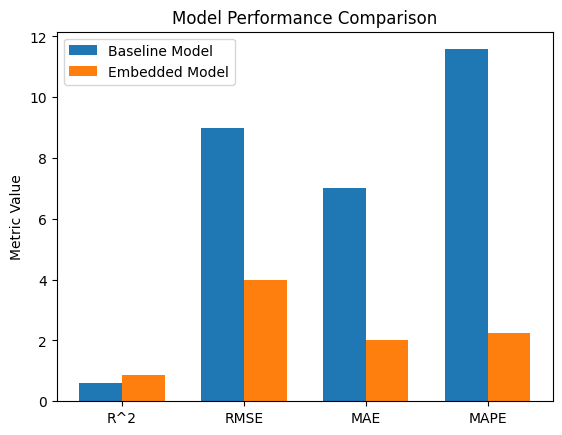

In [38]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

# print(f"RMSE: {rmse:.4f}")
# print(f"MAE: {mae:.4f}")
# print(f"R²: {r2:.4f}")
# print(f"MAPE: {mape:.4f}")


import matplotlib.pyplot as plt
import numpy as np

# Baseline model metrics
baseline_metrics = {
    'R^2': 0.600,
    'RMSE': 9,
    'MAE': 7,
    'MAPE': 11.576
}

# Improved model metrics
# R²: 0.5570
# RMSE: 5.3209
# MAE: 2.9276
# MAPE: 0.0447
embedded_metrics = {
    'R^2': r2,
    'RMSE': rmse,
    'MAE': mae,
    'MAPE': mape,
}

# Metric names for the x-axis
metrics = list(baseline_metrics.keys())

# Metric values for the baseline and improved models
baseline_values = list(baseline_metrics.values())
embedded_values = list(embedded_metrics.values())

# Set the width of the bars
bar_width = 0.35

# Create the bar chart
fig, ax = plt.subplots()

# Bars for the baseline model
baseline_bars = ax.bar(np.arange(len(metrics)), baseline_values, bar_width, label='Baseline Model')

# Bars for the improved model
improved_bars = ax.bar(np.arange(len(metrics)) + bar_width, embedded_values, bar_width, label='Embedded Model')

# Set the x-axis labels and tick positions
ax.set_xticks(np.arange(len(metrics)) + bar_width / 2)
ax.set_xticklabels(metrics)

# Set the y-axis label
ax.set_ylabel('Metric Value')

# Set the title of the chart
ax.set_title('Model Performance Comparison')

# Add a legend
ax.legend()

# Display the chart
plt.show()


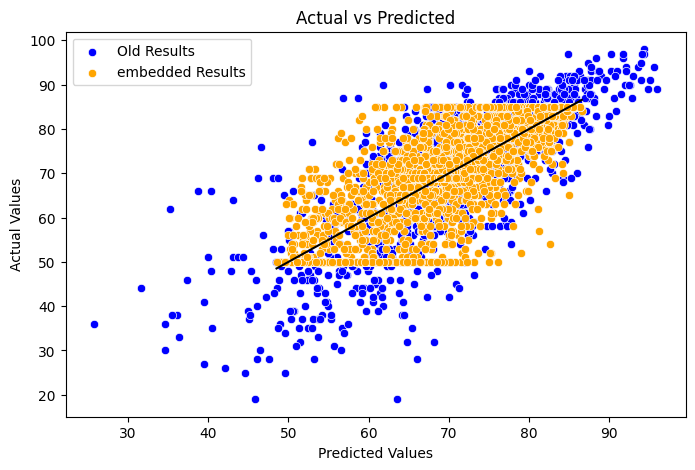

In [39]:
# Create a scatterplot for actual vs predicted values
fig, ax = plt.subplots(figsize=(8, 5))

# Plot old results in blue
sns.scatterplot(x=y_old_pred, y=y_old_test, ax=ax, color='blue', label='Old Results')

# Plot new results in orange
sns.scatterplot(x=y_pred, y=y_test, ax=ax, color='orange', label='embedded Results')

sns.lineplot(x=y_pred, y=y_pred, ax=ax, color='black')

ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values')
ax.set_title('Actual vs Predicted')
ax.legend()

plt.show()

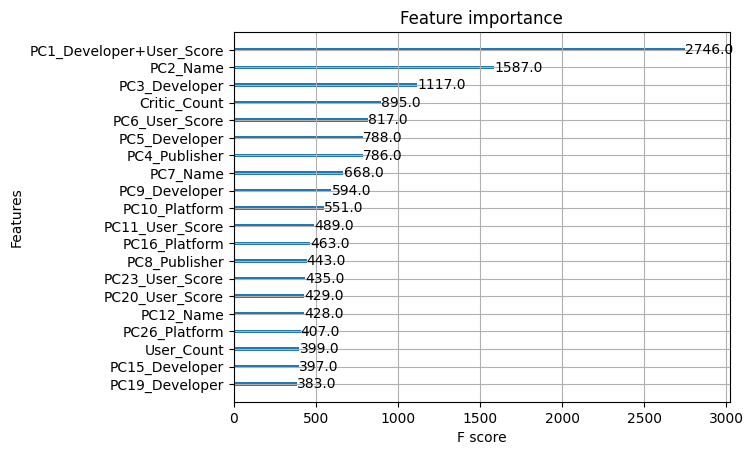

In [40]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

# Plot feature importance
plot_importance(xgb_model, importance_type='weight', max_num_features=20)
plt.show()


100%|===================| 3343/3344 [01:02<00:00]       

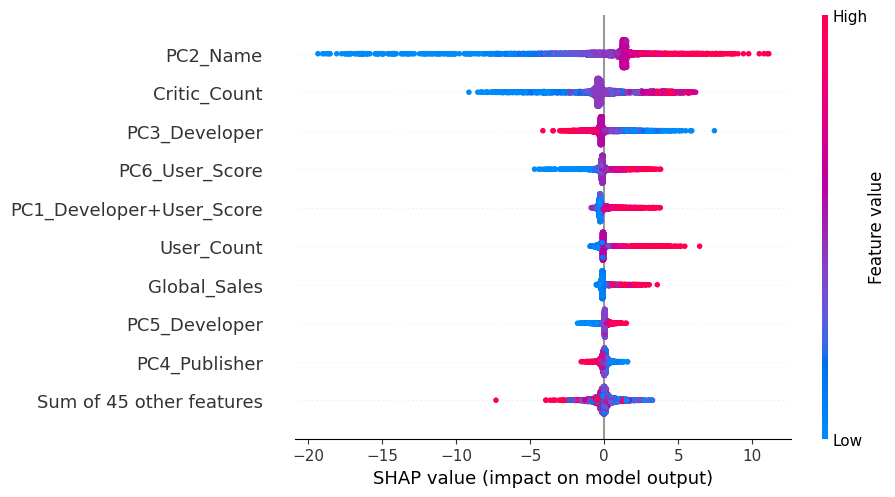

In [41]:
import shap
import numpy as np
# Assuming X_test_final is your final test data with PCA-transformed embeddings and numerical features
# and all_feature_names is your list of feature names (from PCA and num_cols)

# Create a SHAP explainer
explainer_emb = shap.Explainer(xgb_model, test_df) # Use the trained XGBoost model 'xgb_model'

# Calculate SHAP values for X_test_final
shap_values_emb = explainer_emb(test_df) # or explainer_emb.shap_values(X_test_final) if the explainer doesn't accept a DataFrame

# Create a beeswarm plot
shap.plots.beeswarm(shap_values_emb)

<Axes: >

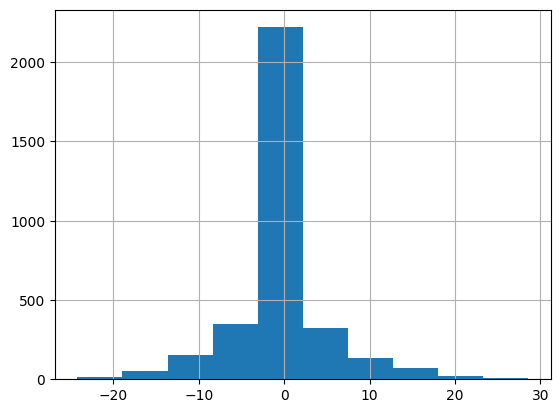

In [42]:
# Calculate prediction residuals
residuals = y_pred - y_test

overestimations = np.sum(residuals > 0)
underestimations = np.sum(residuals < 0)

residuals.hist()

105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


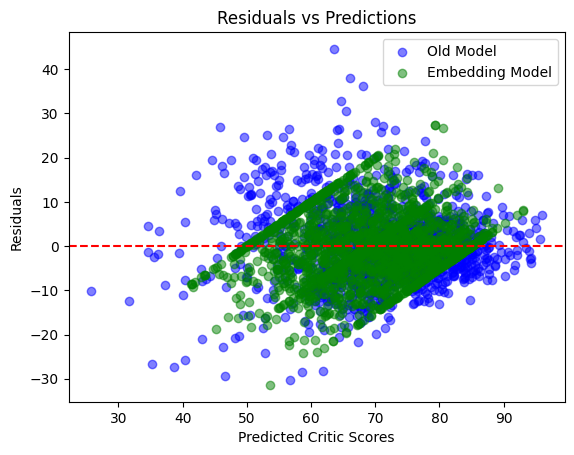

In [43]:

# Get predictions for the embedding model
y_pred_emb = embedding_model_full.predict(cat_test_inputs + [X_test[num_cols]])

# Flatten y_pred_emb before plotting
y_pred_emb = y_pred_emb.flatten()


# Graph 2: Residuals vs. Predictions
residuals_emb = y_pred_emb.flatten() - y_test  # Flatten y_pred_emb
plt.scatter(y_old_pred, old_residuals, alpha=0.5, label="Old Model", color='blue')
plt.scatter(y_pred_emb.flatten(), residuals_emb, alpha=0.5, label="Embedding Model", color='green')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Critic Scores")
plt.ylabel("Residuals")
plt.title("Residuals vs Predictions")
plt.legend()
plt.show()
